In [157]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func/vis')
from vis import vis
import nibabel as nib
from skimage.transform import resize

# Solving border artifact

In [158]:
hof_vlsp = '/nfs/masi/SPORE/lobe/JoHof/fused/'


# Good examples on RML segmentation

In [171]:
metric_dir = "/home/local/VANDERBILT/litz/data/luna16/metrics"
johof_folds = glob.glob(os.path.join(metric_dir, "johof_norm*"))
lsm_folds = glob.glob(os.path.join(metric_dir, "lsm_*"))
model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0418cv_luna16"
# model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0506cval"
al_model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval"
kfolds_path = "/home/local/VANDERBILT/litz/data/luna16/5fold_qa.csv"
# kfolds_path = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/5folds.csv"
fold_paths = get_kfolds(kfolds_path)
unet3d_folds = []
for d, _, _ in os.walk(model_dir):
    unet3d_folds.extend(glob.glob(os.path.join(d, "dataset_rand_test.csv")))
al_folds = []
for d, _, _ in os.walk(al_model_dir):
    al_folds.extend(glob.glob(os.path.join(d, "dataset_rand_test.csv")))

johof_folds = sorted(johof_folds)
lsm_folds = sorted(lsm_folds)
unet3d_folds = sorted(unet3d_folds)
al_folds = sorted(al_folds)

In [172]:
al_folds

['/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold2/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold3/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold4/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold5/dataset_rand_test.csv']

In [173]:
# parse metric csv's into dataframes
johof_df = pd.read_csv(johof_folds[0])
johof_df["fold"] = int(johof_folds[0][-5])
# johof_df["path"] = fold_paths
for i, johof_fold in enumerate(johof_folds):
    if i > 0:
        johof_fold_df = pd.read_csv(johof_fold)
        johof_fold_df["fold"] = int(johof_fold[-5])
        johof_df = pd.concat([johof_df, johof_fold_df], ignore_index=True)
# johof_df.drop(columns=['Unnamed: 0'], inplace=True)

lsm_df = pd.read_csv(lsm_folds[0])
lsm_df["fold"] = int(lsm_folds[0][-5])
for i, lsm_fold in enumerate(lsm_folds):
    if i > 0:
        lsm_fold_df = pd.read_csv(lsm_fold)
        lsm_fold_df["fold"] = int(lsm_fold[-5])
        lsm_df = pd.concat([lsm_df, lsm_fold_df], ignore_index=True)
lsm_df.drop(columns=['Unnamed: 0'], inplace=True)

unet_df = pd.read_csv(unet3d_folds[0])
unet_df["fold"] = int(unet3d_folds[0][-23])
for i, unet3d_fold in enumerate(unet3d_folds):
    if i > 0:
        unet_fold_df = pd.read_csv(unet3d_fold)
        unet_fold_df["fold"] = int(unet3d_fold[-23])
        unet_df = pd.concat([unet_df, unet_fold_df], ignore_index=True)
unet_df.drop(columns=['Unnamed: 0'], inplace=True)

al_df = pd.read_csv(al_folds[0])
al_df["fold"] = int(al_folds[0][-23])
for i, al_fold in enumerate(al_folds):
    if i > 0:
        al_fold_df = pd.read_csv(al_fold)
        al_fold_df["fold"] = int(al_fold[-23])
        al_df = pd.concat([al_df, al_fold_df], ignore_index=True)
al_df.drop(columns=['Unnamed: 0'], inplace=True)

# convert index to column to identify subjects
johof_df['id'] = johof_df.index
lsm_df['id'] = lsm_df.index
unet_df['id'] = unet_df.index
al_df['id'] = al_df.index

In [174]:
pd.set_option('display.max_colwidth', None)
al_df

0         1         2         3         4  \
0   0.973187  0.973336  0.942895  0.784275  0.925650   
1   0.980912  0.975926  0.956717  0.907810  0.966566   
2   0.965828  0.977428  0.963507  0.923020  0.976666   
3   0.938645  0.941528  0.939121  0.828809  0.960739   
4   0.978514  0.973776  0.965877  0.905593  0.938307   
..       ...       ...       ...       ...       ...   
72  0.972982  0.969204  0.961220  0.937658  0.972373   
73  0.916146  0.894923  0.965009  0.944907  0.953961   
74  0.978931  0.977038  0.925101  0.930052  0.955465   
75  0.953747  0.913110  0.951838  0.870724  0.944766   
76  0.985303  0.982931  0.941341  0.925048  0.962126   

                                                                                                                                                   input_path  \
0   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.nii.gz   
1   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.nii.gz   
2   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684.nii.gz   
3   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.nii.gz   
4   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837.nii.gz   
..                                                                                                                                                        ...   
72                                              /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000838time20160730.nii.gz   
73                                              /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001104time20180216.nii.gz   
74                                              /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001034time20180711.nii.gz   
75                                              /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000864time20180205.nii.gz   
76                                              /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001022time20180531.nii.gz   

    fold  id  
0      1   0  
1      1   1  
2      1   2  
3      1   3  
4      1   4  
..   ...  ..  
72     5  72  
73     5  73  
74     5  74  
75     5  75  
76     5  76  

[77 rows x 8 columns]

In [45]:
good_df = al_df[(al_df['3'] >= 0.92)]
print(good_df)
print(good_df['input_path'].values[1])

           0         1         2         3         4  \
2   0.965828  0.977428  0.963507  0.923020  0.976666   
8   0.958783  0.971184  0.955116  0.925498  0.970864   
13  0.986976  0.975982  0.982638  0.966352  0.970001   
14  0.982925  0.984343  0.972811  0.937504  0.980936   
21  0.974407  0.958369  0.958737  0.924001  0.981138   
22  0.965852  0.965155  0.967453  0.936096  0.957139   
24  0.980919  0.972352  0.958598  0.941968  0.955575   
26  0.934006  0.975102  0.963555  0.957050  0.979017   
27  0.966834  0.971014  0.952409  0.922348  0.979464   
28  0.976241  0.974029  0.960385  0.936153  0.956901   
29  0.970997  0.969731  0.937015  0.920240  0.971349   
32  0.985367  0.980930  0.981976  0.946061  0.974433   
37  0.977194  0.975603  0.974287  0.953628  0.973835   
40  0.979958  0.981183  0.967450  0.954975  0.976287   
41  0.956687  0.944510  0.975862  0.936694  0.970766   
42  0.986653  0.981352  0.986102  0.962991  0.975286   
45  0.938130  0.946801  0.974430  0.950667  0.98

In [ ]:
import SimpleITK as sitk
good_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800.mhd'
root_dir = '/home/local/VANDERBILT/litz/data/luna16/preproc_labeled_raw'
hof_dir = '/home/local/VANDERBILT/litz/data/luna16/johof_fused'
lsm_dir = '/home/local/VANDERBILT/litz/data/luna16/lvlsetseg'
raw_path = os.path.join(root_dir, good_id)
hof_path = os.path.join(hof_dir, f"johof_fused_{good_id}")
lsm_path = os.path.join(lsm_dir, f"lvlsetseg_{good_id}")
raw_sitk = sitk.ReadImage(raw_path)
raw_img = np.swapaxes(sitk.GetArrayFromImage(raw_sitk), 0,2)
hof_sitk = sitk.ReadImage(hof_path)
hof_img = np.swapaxes(sitk.GetArrayFromImage(hof_sitk), 0,2)
lsm_sitk = sitk.ReadImage(lsm_path)
lsm_img = np.swapaxes(sitk.GetArrayFromImage(lsm_sitk), 0,2)

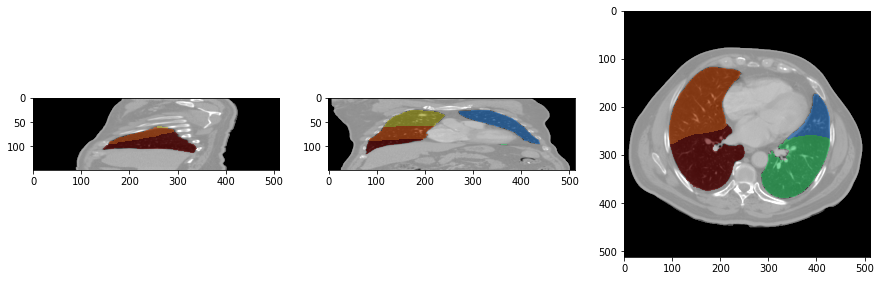

In [ ]:
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func/vis')
from vis import vis

def clip_LPS(img, xyz):
    x, y, z = xyz
    clip_sag = img[x, :, :]
    clip_sag = np.rot90(clip_sag)
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = img[:, :, z]
    clip_ax = np.flip(clip_ax, 0)
    clip_ax = np.rot90(clip_ax, 3)
    return (clip_sag, clip_cor, clip_ax)

def vis_overlay_slices(img, label, xyz, orientation="LAS", cmap="turbo", clip_range=(-1024, 600), mask_range=(0,5)):
    label = np.where(label == 0, np.nan, label)
    img_clip_sag, img_clip_cor, img_clip_ax = clip_LAS(img, xyz) if orientation == "LAS" else clip_LPS(img, xyz)
    label_clip_sag, label_clip_cor, label_clip_ax = clip_LAS(label, xyz) if orientation == "LAS" else clip_LPS(label,
                                                                                                               xyz)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))

    sag = ax[0].imshow(img_clip_sag, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0],
                       vmax=clip_range[1])
    ax[0].imshow(label_clip_sag, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[1].imshow(img_clip_cor, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[1].imshow(label_clip_cor, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[2].imshow(img_clip_ax, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[2].imshow(label_clip_ax, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])

xyz=(100,200,75)
vis.vis_overlay_slices(raw_img, hof_img, xyz, orientation="LPS", cmap="turbo")

In [13]:
# function that maps an input int (as str type) to name of lobe
def lobe_map(x):
    if x=='0': return 'LUL'
    if x=='1': return 'LLL'
    if x=='2': return 'RUL'
    if x=='3': return 'RML'
    if x=='4': return 'RLL'
# johof_df['id'] = pd.Series(range(0, len(johof_df)))
# lsm_df['id'] = pd.Series(range(0, len(lsm_df)))
# unet_df['id'] = pd.Series(range(0, len(unet_df)))
# convert wide to long form
johof_long = pd.melt(johof_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
johof_long['model'] = 'Hof.'
lsm_long = pd.melt(lsm_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
lsm_long['model'] = 'LSM'
unet_long = pd.melt(unet_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
unet_long['model'] = '3DUnet'
al_long = pd.melt(al_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
al_long['model'] = 'AL'

all_df = pd.concat([johof_long, lsm_long, unet_long, al_long], ignore_index=True)
# # convert lobe numbers to names
all_df = all_df.rename(columns={'variable':'Lobe', 'value': 'Dice score'})
all_df['Lobe'] = all_df['Lobe'].apply(lobe_map)


In [23]:
all_df[(all_df['model']=='AL') & (all_df['Lobe']=='RML')]

id  fold Lobe  Dice score model
846   0     1  RML    0.784275    AL
847   1     1  RML    0.907810    AL
848   2     1  RML    0.923020    AL
849   3     1  RML    0.828809    AL
850   4     1  RML    0.905593    AL
851   5     1  RML    0.876051    AL
852   6     1  RML    0.810034    AL
853   7     1  RML    0.626814    AL
854   8     1  RML    0.925498    AL
855   9     2  RML    0.901483    AL
856  10     2  RML    0.907160    AL
857  11     2  RML    0.054860    AL
858  12     2  RML    0.714088    AL
859  13     2  RML    0.966352    AL
860  14     2  RML    0.937504    AL
861  15     2  RML    0.893234    AL
862  16     2  RML    0.908384    AL
863  17     2  RML    0.889088    AL
864  18     3  RML    0.833114    AL
865  19     3  RML    0.892525    AL
866  20     3  RML    0.836636    AL
867  21     3  RML    0.924001    AL
868  22     3  RML    0.936096    AL
869  23     3  RML    0.607652    AL
870  24     3  RML    0.941968    AL
871  25     3  RML    0.897268    AL
872  26     3  RML    0.957050    AL
873  27     4  RML    0.922348    AL
874  28     4  RML    0.936153    AL
875  29     4  RML    0.920240    AL
876  30     4  RML    0.856618    AL
877  31     4  RML    0.918046    AL
878  32     4  RML    0.946061    AL
879  33     4  RML    0.903851    AL
880  34     4  RML    0.876084    AL
881  35     4  RML    0.702128    AL
882  36     5  RML    0.216661    AL
883  37     5  RML    0.953628    AL
884  38     5  RML    0.916029    AL
885  39     5  RML    0.762104    AL
886  40     5  RML    0.954975    AL
887  41     5  RML    0.936694    AL
888  42     5  RML    0.962991    AL
889  43     5  RML    0.788663    AL
890  44     5  RML    0.902382    AL
891  45     5  RML    0.950667    AL
892  46     5  RML    0.848625    AL

# Run Inference

In [62]:
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/')
from dataloader import test_dataloader
from models import unet512
import yaml
import random
import torch
from monai.utils import set_determinism
from monai.metrics import DiceMetric

def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_id = "test"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0")

In [63]:
DATA_DIR = config["data_dir"]
# scanid = "00001124time20180105" # good example
# scanid = "00001121time20180510" # bad example
# images = sorted(glob.glob(os.path.join(DATA_DIR, f"{scanid}.nii.gz")))
images = sorted(glob.glob(os.path.join(DATA_DIR, f"0*"))) # search for active learning images only
print(config["dataset"])

vlsp


In [64]:
from monai.transforms import (
    LoadImaged,
    Orientationd,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    EnsureTyped,
    CropForegroundd,
    Invertd,
    Compose,
)
from monai.data import DataLoader, Dataset
def test_dataloader(config, val_images):
    test_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=config["pix_dim"], mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
                             clip=True),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ])
    invert_transforms = Compose([
        EnsureTyped(keys="pred"),
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        # AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        # AsDiscreted(keys="label", to_onehot=6)
    ])
    LABEL_DIR = config["label_dir"]

    if config["dataset"] == "vlsp":
        val_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in val_images]
    elif config["dataset"] == "luna16":
        val_file_names = [f"{os.path.basename(name)[:-4]}_LobeSegmentation.nrrd" for name in val_images]
    elif config["dataset"] == "mixed":
        val_file_names = []
        for i in val_images:
            name, suffix = os.path.splitext(os.path.basename(i))
            if suffix == ".mhd":
                val_file_names.append(f"{name}_LobeSegmentation.nrrd")
            elif suffix == ".gz":
                fname = f"{name[:-4]}_LobeSegmentation.nii.gz" if name[1] == '.' else f"{name[:-4]}_lvlsetseg.nii.gz"
                val_file_names.append(fname)
    else:
        print("Error: define dataset in Config.YAML")
        return
    val_labels = [os.path.join(LABEL_DIR, name) for name in val_file_names]
    val_files = [
        {"image": image_name, "label": label_name, "image_path": image_name}
        for image_name, label_name in zip(val_images, val_labels)
    ]
    test_ds = Dataset(data=val_files, transform=test_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, shuffle=False)
    return test_loader, invert_transforms


In [34]:
test_loader, invert_transforms = test_dataloader(config, images)

model = unet512(6).to(device)
model_path = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/0511cval_best_model.pth"

test_metric = DiceMetric(include_background=False, reduction="none")
metrics_path = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp"
seg_dir = False
clip_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures/dataset_rand_clips"

In [35]:
import os
import sys
from tqdm import tqdm
import torch
import SimpleITK as sitk
import gc
import psutil
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    Compose,
    AsDiscrete,
    AddChannel,
    EnsureType,
    EnsureTyped,
    AsDiscreted,
)
from pandas import DataFrame
import numpy as np
from postprocess import get_largest_cc, nearest_label_filling
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func")
import vis.paral_clip_overlay_mask as overlay

def test(config,
         config_id,
         device,
         model,
         model_path,
         test_metric,
         test_loader,
         invert_transforms,
         metrics_path,
         seg_dir,
         clip_dir):
    device = torch.device(config["device"])
    model.load_state_dict(torch.load(model_path))
    model.eval()

    post_pred_transforms = Compose([
        EnsureTyped(keys=["label", "pred"]),
        AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        AsDiscreted(keys="label", to_onehot=6)
    ])
    measure_transforms = Compose([EnsureType(), AddChannel(), AsDiscrete(to_onehot=6)])
    image_paths = []
    # reader = sitk.ImageFileReader()
    # print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, label, image_path = (
                test_data["image"].to(device),
                test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
                test_data["image_path"][0]
            )
            image_paths.append(image_path)
            test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
            test_data = [post_pred_transforms(i) for i in decollate_batch(test_data)]
            test_data = test_data[0]
            # postprocces with CC and nearest label filling
            postprocess = torch.argmax(test_data["pred"], dim=0)
            postprocess = postprocess.detach().cpu().numpy()
            postprocess = nearest_label_filling(postprocess, get_largest_cc(postprocess))
            test_data["pred"] = measure_transforms(postprocess)
            #
            # print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
            # accumulate dice
            test_metric(y_pred=[test_data["pred"]], y=[test_data["label"]])
            # dice of this example's RML
            rml_dice = test_metric.aggregate()[-1][3]

            # pred_img_space = invert_transforms(test_data)["pred"]
            # pred_img_space = torch.argmax(pred_img_space, dim=0)

            raw = test_data["image"].detach().cpu().numpy()
            raw = raw[0,:,:,:]
            # fname = os.path.basename(image_path)[:-4] if config["dataset"]=="luna16" else os.path.basename(image_path).split(".")[0]
            fname = os.path.basename(image_path)[:-7]
            overlay.multiple_clip_overlay_with_mask_from_npy(raw, postprocess, os.path.join(clip_dir, f"pred_{fname}_coronal.png"), clip_plane='coronal', img_vrange=(0, 1))
            overlay.multiple_clip_overlay_with_mask_from_npy(raw, label, os.path.join(clip_dir, f"label_{fname}_coronal.png"), clip_plane='coronal', img_vrange=(0, 1))
            overlay.multiple_clip_overlay_with_mask_from_npy(raw, postprocess,
                                                             os.path.join(clip_dir, f"pred_{fname}_axial.png"),
                                                             clip_plane='axial', img_vrange=(0, 1))
            overlay.multiple_clip_overlay_with_mask_from_npy(raw, label,
                                                         os.path.join(clip_dir, f"label_{fname}_axial.png"),
                                                         clip_plane='axial', img_vrange=(0, 1))


        # Total dice over test set
#         test_dices = test_metric.aggregate()

#         # Record metrics and compute mean over test set
#         class_means = torch.mean(test_dices, dim=0)
#         mean = torch.mean(test_dices)

#         # store in dataframe with image path
#         test_dices_df = DataFrame(test_dices.detach().cpu().numpy())
#         test_dices_df["input_path"] = image_paths

In [67]:
from monai.transforms import Orientation, Spacing

def run_inference(image, pixdim, config, config_id, device, model, model_path, test_metric):
    test_loader, _ = test_dataloader(config, image)
    device = torch.device(config["device"])
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_metric.reset()

    post_pred_transforms = Compose([
        EnsureTyped(keys=["label", "pred"]),
        AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        AsDiscreted(keys="label", to_onehot=6)
    ])
    measure_transforms = Compose([EnsureType(), AddChannel(), AsDiscrete(to_onehot=6)])
    vis_transforms = Compose([EnsureType(), AddChannel(), Spacing(pixdim=pixdim, mode="nearest"), Orientation(axcodes="LAS"),])
    image_paths = []
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, image_path = (
                test_data["image"].to(device),
                # test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
                test_data["image_path"][0]
            )
            image_paths.append(image_path)
            test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
            test_data = [post_pred_transforms(i) for i in decollate_batch(test_data)]
            test_data = test_data[0]
            # postprocces with CC and nearest label filling
            postprocess = torch.argmax(test_data["pred"], dim=0)
            postprocess = postprocess.detach().cpu().numpy()
            postprocess = nearest_label_filling(postprocess, get_largest_cc(postprocess))

            # print dice
            test_data["pred"] = measure_transforms(postprocess)
            # test_metric(y_pred=[test_data["pred"]], y=[test_data["label"]])
            # print(test_metric.aggregate())
            
            # pred_img_space = invert_transforms(test_data)["pred"]
            # pred_img_space = torch.argmax(pred_img_space, dim=0)
            
            # transform to image space orientation
            print(f"before transform {postprocess.shape}")
            postprocess = vis_transforms(postprocess)[0][0][0]
            print(f"after transform {postprocess.shape}")
            
    return postprocess



# Qualitative figure

In [18]:
images = ["00000045time20170920", # example of bad LSM that Unet fixes
          "00000667time20170526", # example of good segmentation of a challenging middle lobe
          "00001033time20181022", # example of goo
         ]

raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/train_preproc"
johof_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/johof/"
lsm_dir = "/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/"
truth_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/label_nifti/"
raw_paths = [os.path.join(raw_dir, f"{i}.nii.gz") for i in images]
johof_paths = [os.path.join(johof_dir, f"johof_{i}.nii.gz") for i in images]
lsm_paths = [os.path.join(lsm_dir, f"lvlsetseg_{i}.nii.gz") for i in images]
truth_paths = [os.path.join(truth_dir, f"{i}_lvlsetseg.nii.gz") for i in images]


In [122]:
raws = []
johofs = []
lsms = []
truths = []
unets = []

for i in range(len(images)):
    # get johof and lsm
    raw_nii = nib.load(raw_paths[i])
    raw_img = raw_nii.get_fdata()
    johof_img = nib.load(johof_paths[i]).get_fdata()
    lsm_img = nib.load(lsm_paths[i]).get_fdata()
    truth_img = nib.load(truth_paths[i]).get_fdata()
    s = raw_img.shape
    pixdim = raw_nii.header.get_zooms()
    
    resize_lsm_img = resize(lsm_img, s, order=0)
    
    # get model inference
    unet_img = run_inference([raw_paths[i]], pixdim, config, config_id, device, model, model_path, test_metric)
    raws.append(raw_img)
    johofs.append(johof_img)
    lsms.append(resize_lsm_img)
    truths.append(truth_img)
    unets.append(unet_img)

tensor([[0.9824, 0.9785, 0.9827, 0.9608, 0.9822]])
before transform (351, 351, 347)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 433])
tensor([[0.9774, 0.9781, 0.9768, 0.9605, 0.9754]])
before transform (387, 387, 315)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 393])
tensor([[0.9815, 0.9744, 0.9731, 0.8708, 0.9622]])
before transform (350, 350, 331)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 408])


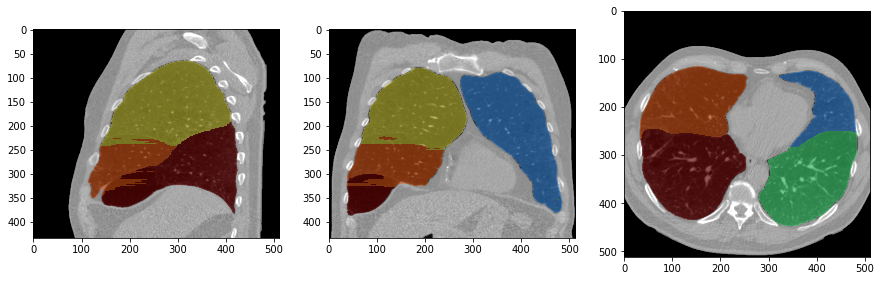

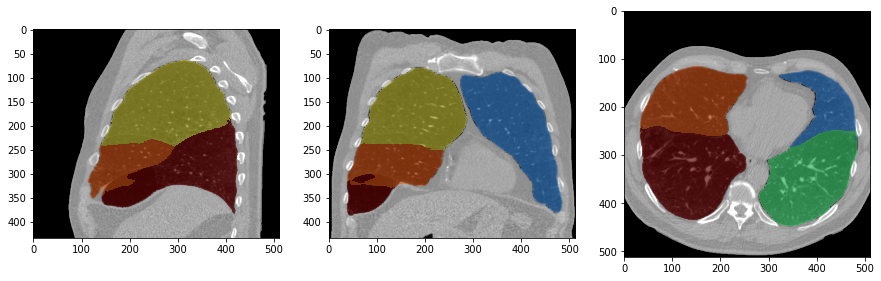

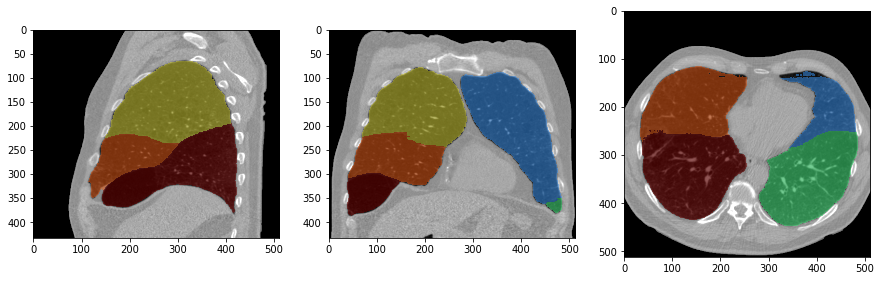

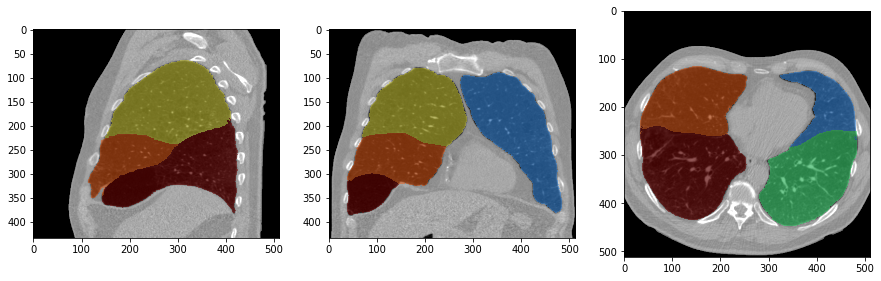

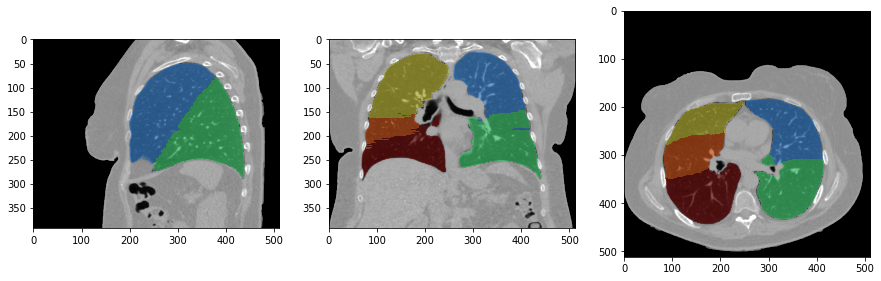

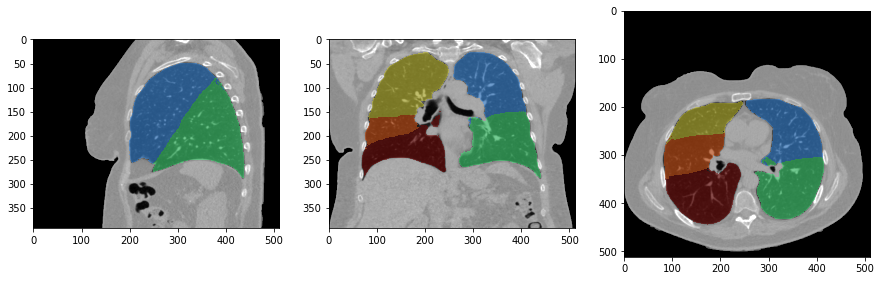

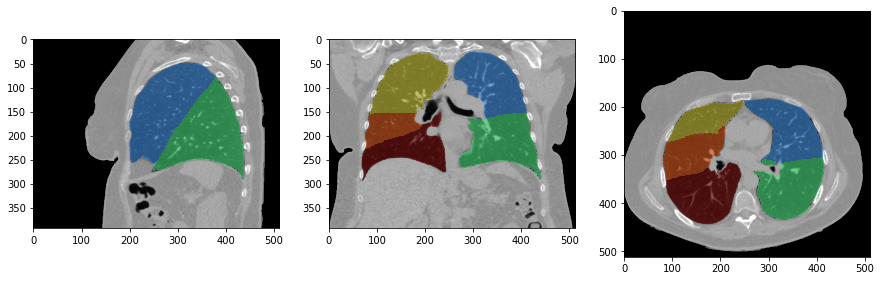

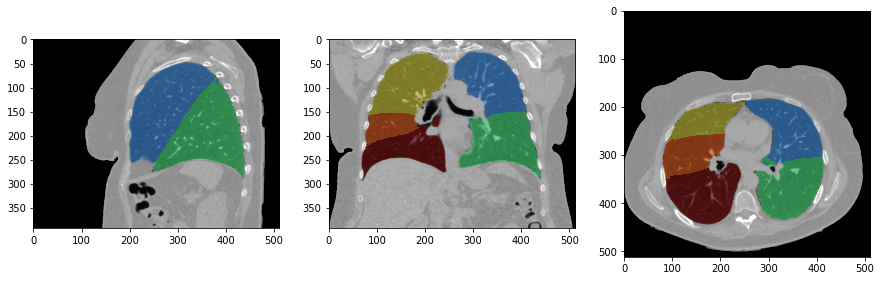

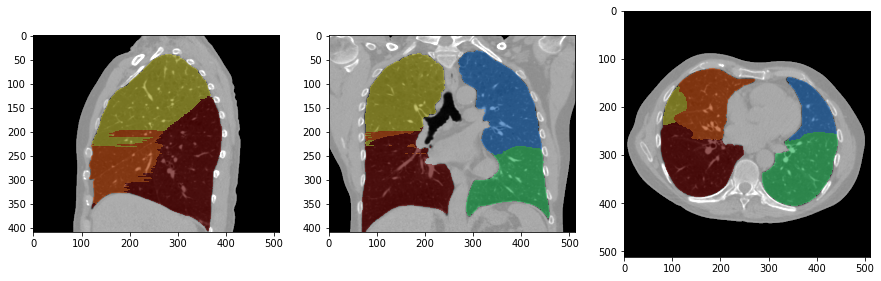

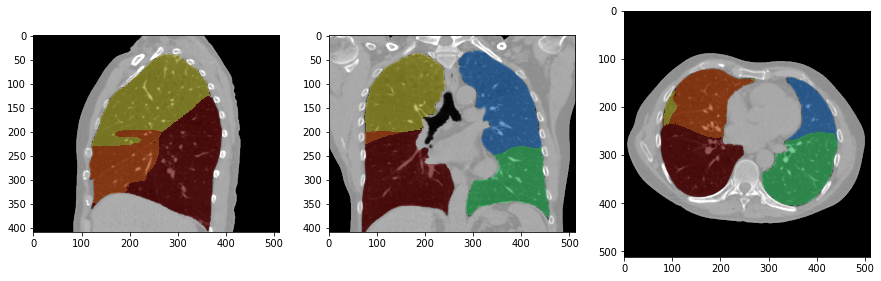

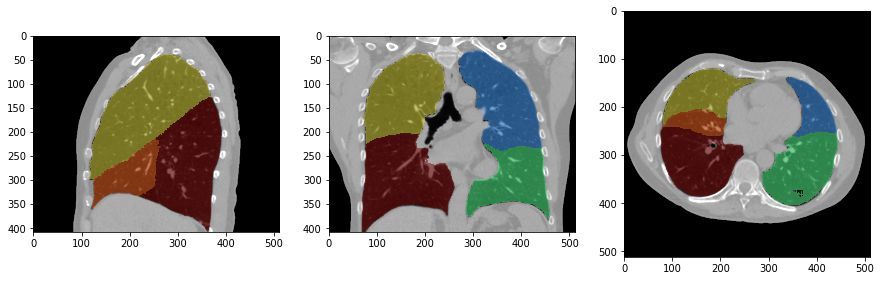

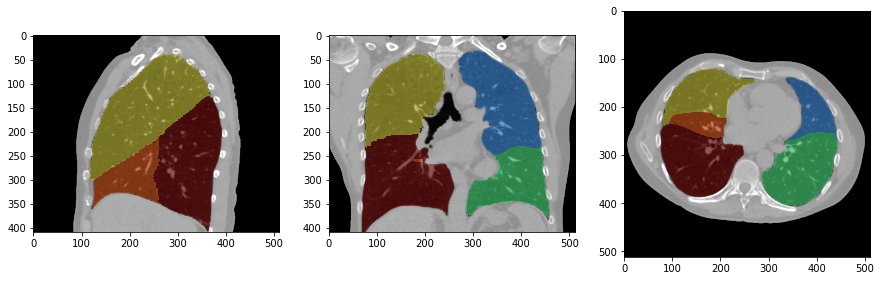

In [186]:
fig_dir = '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures'
xyzs = [(100,320,150), (365, 192, 224), (165, 243, 161)]
    
for i, xyz in enumerate(xyzs):
    vis.vis_overlay_slices(raws[i], johofs[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{i}_johof.png"))
    vis.vis_overlay_slices(raws[i], lsms[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{i}_lsm.png"))
    vis.vis_overlay_slices(raws[i], unets[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{i}_unet.png"))
    vis.vis_overlay_slices(raws[i], truths[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{i}_truth.png"))
    
# xyz = (365, 192, 224)
# print(raws[2].shape)
# vis.vis_overlay_slices(raws[1], johofs[1], xyz, orientation="LAS", cmap="turbo")
# vis.vis_overlay_slices(raws[1], lsms[1], xyz, orientation="LAS", cmap="turbo")
# vis.vis_overlay_slices(raws[1], unets[1], xyz, orientation="LAS", cmap="turbo")
# vis.vis_overlay_slices(raws[1], truths[1], xyz, orientation="LAS", cmap="turbo")

In [98]:
# LUNA16 figures
luna_images = ["1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796"]
raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/"
johof_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/johof/"
truth_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/label_nifti/"
raw_paths = [os.path.join(raw_dir, f"{i}.nii.gz") for i in luna_images]
johof_paths = [os.path.join(johof_dir, f"johof_{i}.nii.gz") for i in luna_images]
truth_paths = [os.path.join(truth_dir, f"{i}_LobeSegmentation.nii.gz") for i in luna_images]

for i in range(len(luna_images)):
    raw_nii = nib.load(raw_paths[i])
    raw_img = raw_nii.get_fdata()
    johof_img = nib.load(johof_paths[i]).get_fdata()
    truth_img = nib.load(truth_paths[i]).get_fdata()
    pixdim = raw_nii.header.get_zooms()
    
    unet_img = run_inference([raw_paths[i]], pixdim, config, config_id, device, model, model_path, test_metric)

tensor([[0.9830, 0.9743, 0.8743, 0.6437, 0.9485]])
before transform (450, 450, 346)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 277])


IndexError: list index out of range

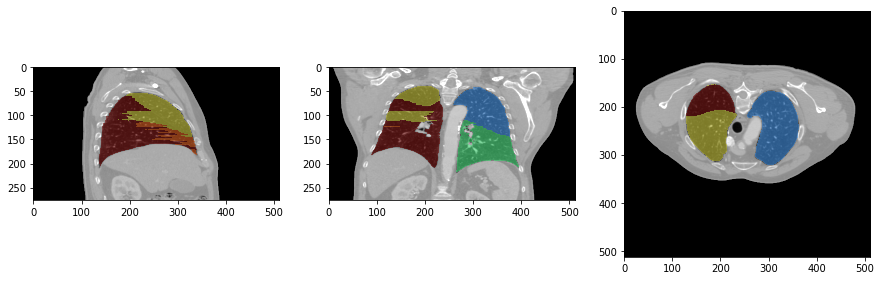

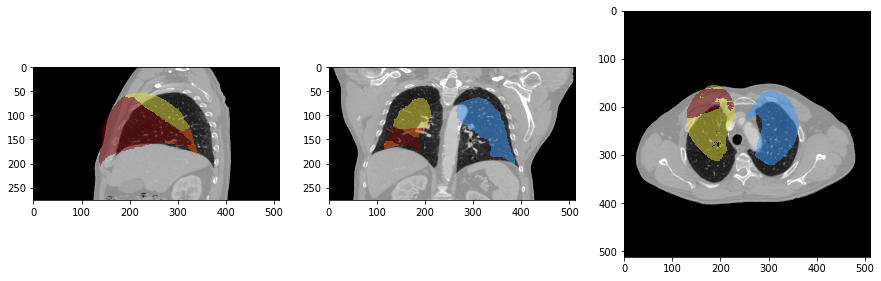

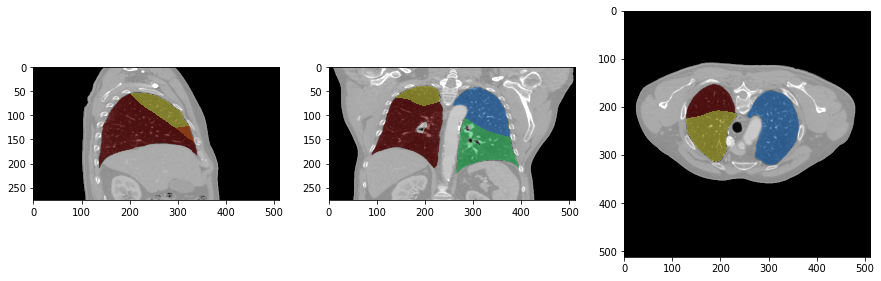

In [107]:
xyz = (150,300,200)
vis.vis_overlay_slices(raw_img, johof_img, xyz, orientation="LAS", cmap="turbo")
vis.vis_overlay_slices(raw_img, unet_img, xyz, orientation="LPS", cmap="turbo")
vis.vis_overlay_slices(raw_img, truth_img, xyz, orientation="LAS", cmap="turbo")

# High emphysema cases

In [25]:
import pandas as pd
raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc"
emphys_path = "/home/local/VANDERBILT/litz/github/MASILab/emphysema/data/JoHof_fused_results.csv"
edf = pd.read_csv(emphys_path, dtype={"pid":str})
edf

pid   session       Section  Lobe Volume         LAV     LAV %  \
0      00000251  20180711    Left upper  1051.753392  174.987312  0.166377   
1      00000251  20180711    Left lower  1274.740896  149.558682  0.117325   
2      00000251  20180711   Right upper   891.853766  123.440129  0.138408   
3      00000251  20180711  Right middle   446.401369   66.018264  0.147890   
4      00000251  20180711   Right lower  1226.648213  167.282738  0.136374   
...         ...       ...           ...          ...         ...       ...   
11915  00000721  20170710  Right middle   297.628939    0.696839  0.002341   
11916  00000721  20170710   Right lower  1034.989917    2.778382  0.002684   
11917  00000721  20170710          Left  1948.643944    5.863313  0.003009   
11918  00000721  20170710         Right  2213.967464    5.397508  0.002438   
11919  00000721  20170710           All  4162.611408   11.260821  0.002705   

       Residual Volume  Residual %  
0           876.766079    0.833623  
1          1125.182214    0.882675  
2           768.413637    0.861592  
3           380.383106    0.852110  
4          1059.365475    0.863626  
...                ...         ...  
11915       296.932101    0.997659  
11916      1032.211535    0.997316  
11917      1942.780631    0.996991  
11918      2208.569956    0.997562  
11919      4151.350587    0.997295  

[11920 rows x 8 columns]

In [26]:
high_edf = edf[(edf["Section"]=="All") & (edf["LAV %"] > 0.2)]
# high_edf
high_pid = high_edf['pid'].tolist()
raw_paths = [os.path.join(raw_dir, f"{row['pid']}time{row['session']}.nii.gz") for i, row in high_edf.iterrows()]
# print(raw_paths)

['/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000999time20180322.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00001022time20180531.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00001052time20180411.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00001058time20180112.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000128time20150728.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000122time20170719.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170504.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20171002.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170807.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000765time20170809.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00001045time20180329.nii.gz', '/home/local/VANDERBILT/litz/data/imagevu/nifti/prepr

In [112]:
raws = []
unets = []
for path in raw_paths[5:10]:
    raw_nii = nib.load(path)
    raw_img = raw_nii.get_fdata()
    pixdim = raw_nii.header.get_zooms()
    unet_img = run_inference([path], pixdim, config, config_id, device, model, model_path, test_metric)
    
    raws.append(raw_img)
    unets.append(unet_img)


[{'image': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000122time20170719.nii.gz', 'label': '/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/lvlsetseg_00000122time20170719.nii.gz', 'image_path': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000122time20170719.nii.gz'}]
before transform (378, 378, 335)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 419])
[{'image': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170504.nii.gz', 'label': '/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/lvlsetseg_00000486time20170504.nii.gz', 'image_path': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170504.nii.gz'}]
before transform (411, 411, 378)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 472])
[{'image': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20171002.nii.gz', 'label': '/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/lvlsetseg_00000486time20171002.nii.gz', 'image_path': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20171002.nii.gz'}]
before transform (406, 406, 354)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 442])
[{'image': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170807.nii.gz', 'label': '/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/lvlsetseg_00000486time20170807.nii.gz', 'image_path': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000486time20170807.nii.gz'}]
before transform (390, 390, 353)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 441])
[{'image': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000765time20170809.nii.gz', 'label': '/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/lvlsetseg_00000765time20170809.nii.gz', 'image_path': '/home/local/VANDERBILT/litz/data/imagevu/nifti/preproc/00000765time20170809.nii.gz'}]
before transform (386, 386, 298)


axcodes ('LAS') length is smaller than the number of input spatial dimensions D=1.
Orientation: input spatial shape is (4,), num. channels is 4,please make sure the input is in the channel-first format.


after transform torch.Size([512, 512, 372])


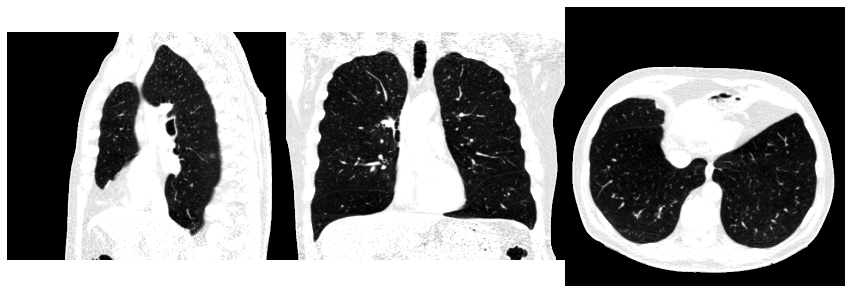

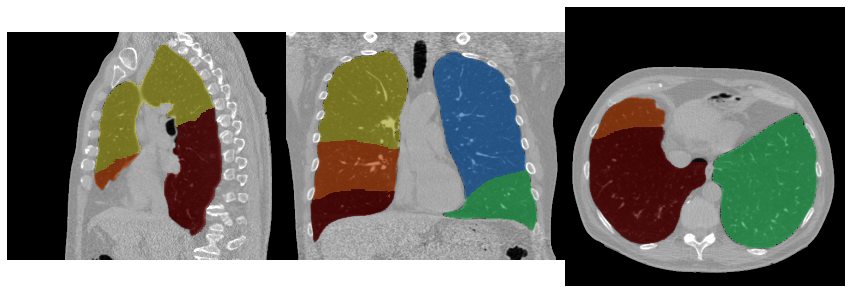

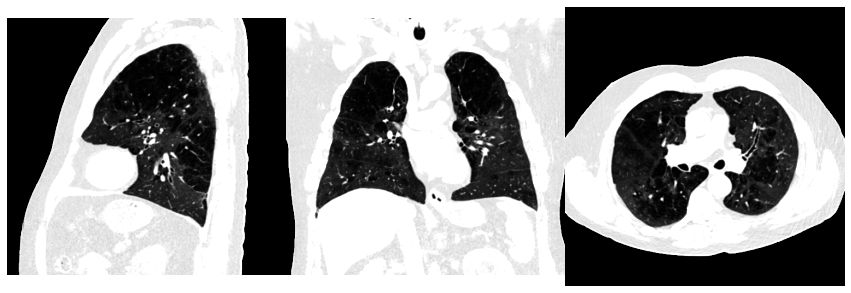

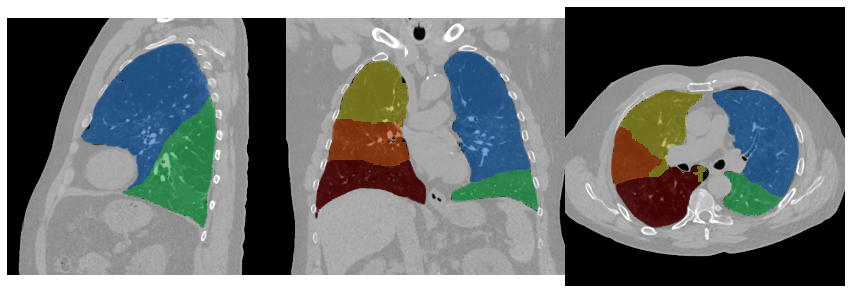

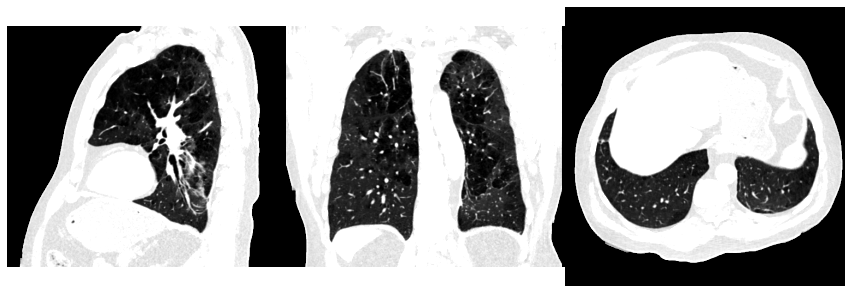

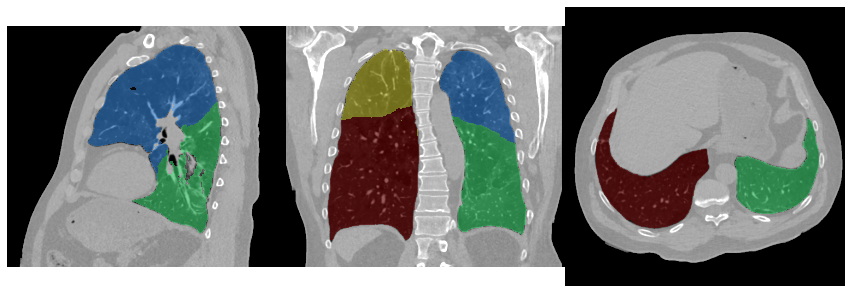

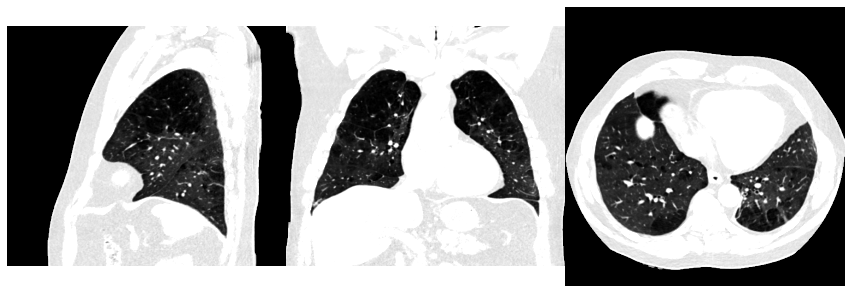

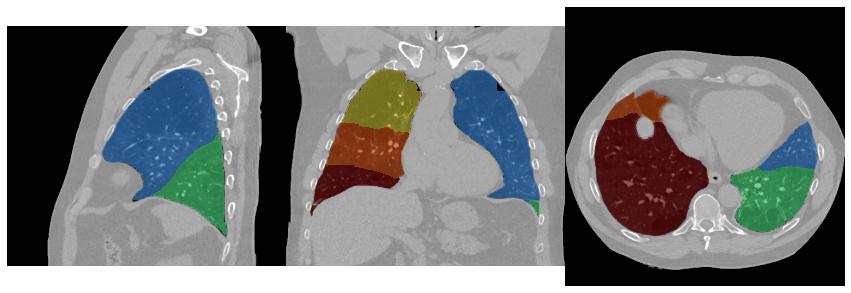

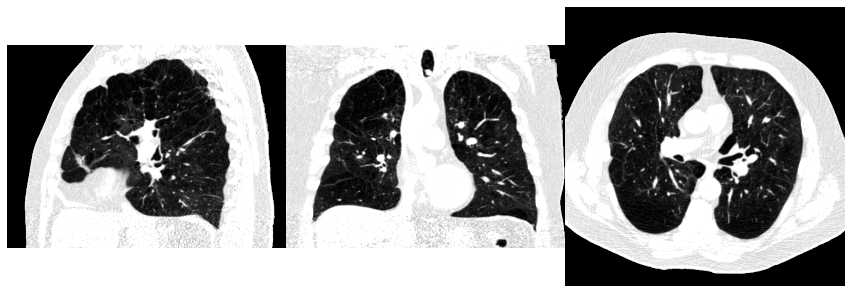

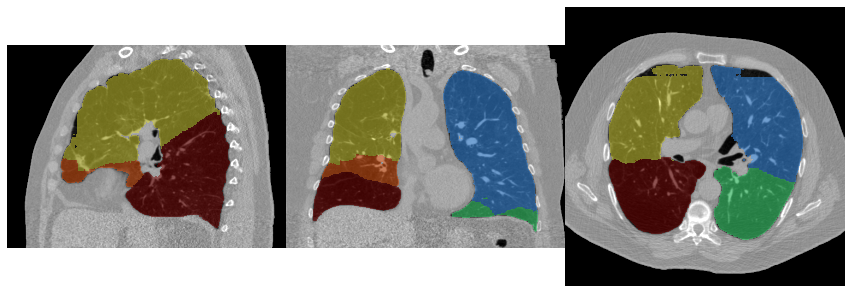

In [156]:
fig_dir = '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures'
xyzs = [(215, 250, 90), (350, 260, 280), (330, 160, 100), (400, 260, 150), (200, 280, 180)]
    
for i, xyz in enumerate(xyzs):
    vis_slices(raws[i], xyz, clip_range=(-1000,0))
    plt.savefig(os.path.join(fig_dir, f"vlsp_raw_1_{i}"))
    vis_overlay_slices(raws[i], unets[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"vlsp_seg_1_{i}"))
# plt.axis('off')


In [91]:
def vis_slices(img, xyz=(100,100,100), orientation="LAS", cmap="gray", clip_range=(-1024, 600)):

    if orientation=="LAS":
        clip_sag, clip_cor, clip_ax = vis.clip_LAS(img, xyz)
    elif orientation=="LPS":
        clip_sag, clip_cor, clip_ax = vis.clip_LPS(img, xyz)
    elif orientation=="Identity":
        clip_sag, clip_cor, clip_ax = vis.clip_Identity(img, xyz)

    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))
    sag = ax[0].imshow(clip_sag, interpolation='bilinear', cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1].imshow(clip_cor, interpolation='bilinear', cmap=cmap, vmin=vmin, vmax=vmax)
    ax[2].imshow(clip_ax, interpolation='bilinear', cmap=cmap, vmin=vmin, vmax=vmax)
    for a in ax:
        a.axis('off')
    for a in ax:
        a.axis('off')
        a.set_xticklabels([])
        a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    
def vis_overlay_slices(img, label, xyz, orientation="LAS", cmap="turbo", clip_range=(-1024, 600), mask_range=(0,5)):
    label = np.where(label == 0, np.nan, label)
    img_clip_sag, img_clip_cor, img_clip_ax = vis.clip_LAS(img, xyz) if orientation == "LAS" else vis.clip_LPS(img, xyz)
    label_clip_sag, label_clip_cor, label_clip_ax = vis.clip_LAS(label, xyz) if orientation == "LAS" else vis.clip_LPS(label,
                                                                                                               xyz)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))

    sag = ax[0].imshow(img_clip_sag, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0],
                       vmax=clip_range[1])
    ax[0].imshow(label_clip_sag, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[1].imshow(img_clip_cor, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[1].imshow(label_clip_cor, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[2].imshow(img_clip_ax, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[2].imshow(label_clip_ax, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    for a in ax:
        a.axis('off')
        a.set_xticklabels([])
        a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)